In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation

from agent import DQNAgent
from utils import preprocess_state, show_epsilon_decay, show_frame, PlotResults

# Setup

# Deep Q-Network

### Test on CartPole env

In [2]:
env = gym.make('CartPole-v1')
n_actions, n_observations = env.action_space.n, env.observation_space.shape[0]
n_observations = (n_observations, )

dqn_agent = DQNAgent(
    model='DQN',
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.01,
    epsilon_decay=1e-4,
    tau=0.005,
    lr=1e-3,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = PlotResults()
n_episodes = 350

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn_agent.store_transition(state, action, next_state, reward, done)
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")

Episode 0, Average Reward: 55.00, Epsilon: 0.95
Episode 10, Average Reward: 20.00, Epsilon: 0.93
Episode 20, Average Reward: 20.80, Epsilon: 0.91
Episode 30, Average Reward: 28.20, Epsilon: 0.89
Episode 40, Average Reward: 31.90, Epsilon: 0.86
Episode 50, Average Reward: 27.30, Epsilon: 0.84
Episode 60, Average Reward: 26.90, Epsilon: 0.81
Episode 70, Average Reward: 33.30, Epsilon: 0.79
Episode 80, Average Reward: 38.80, Epsilon: 0.76
Episode 90, Average Reward: 29.90, Epsilon: 0.74
Episode 100, Average Reward: 42.40, Epsilon: 0.70
Episode 110, Average Reward: 38.20, Epsilon: 0.68
Episode 120, Average Reward: 81.80, Epsilon: 0.62
Episode 130, Average Reward: 45.10, Epsilon: 0.60
Episode 140, Average Reward: 89.70, Epsilon: 0.55
Episode 150, Average Reward: 125.50, Epsilon: 0.48
Episode 160, Average Reward: 60.60, Epsilon: 0.45
Episode 170, Average Reward: 62.60, Epsilon: 0.43
Episode 180, Average Reward: 78.90, Epsilon: 0.39
Episode 190, Average Reward: 78.10, Epsilon: 0.36
Episode 20

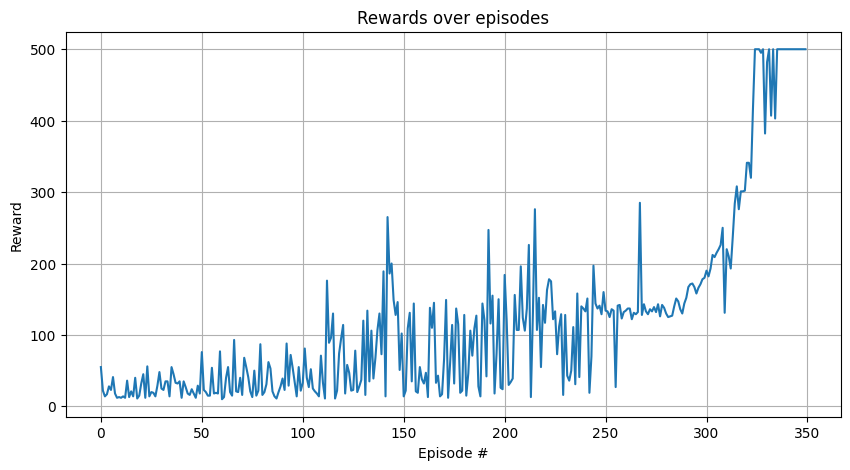

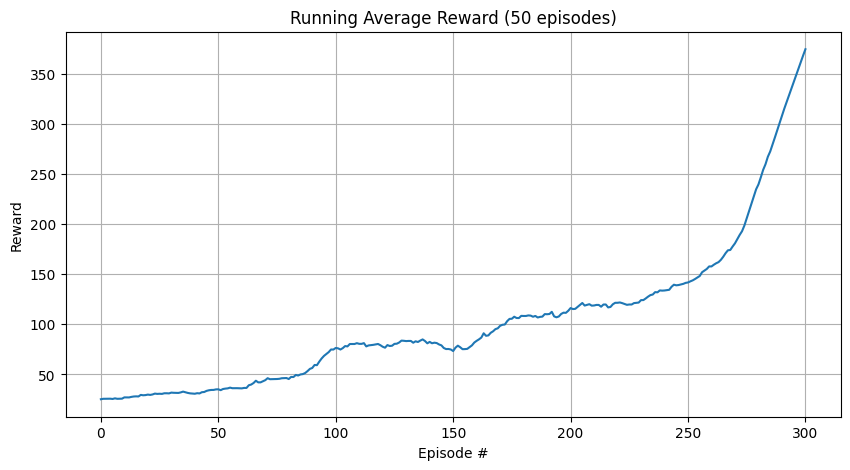

45538


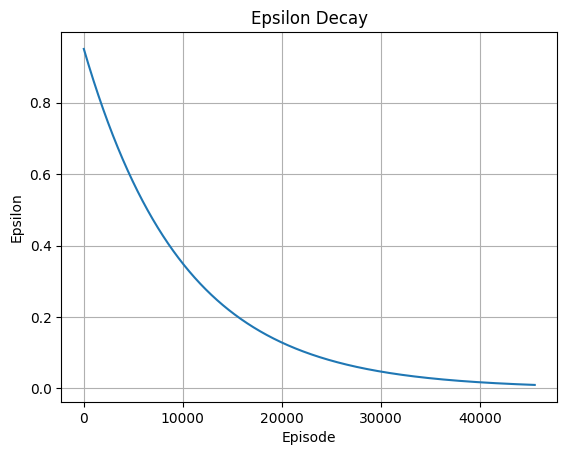

In [5]:
# Plot the rewards
rewards_storer.plot_rewards()
rewards_storer.plot_rewards_smooth(window_length=50)
show_epsilon_decay(dqn_agent.epsilon_start, dqn_agent.epsilon_min, dqn_agent.epsilon_decay)

### Test on LunarLander env

In [104]:
env = gym.make('LunarLander-v3', continuous=False)
# print(env.action_space)
n_actions, n_observations = env.action_space.n, env.observation_space.shape[0]
n_observations = (n_observations, )

dqn_agent = DQNAgent(
    model='DQN',
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.01,
    epsilon_decay=2.5e-5,
    tau=0.005,
    lr=1e-4,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = PlotResults()
n_episodes = 400

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn_agent.store_transition(state, action, next_state, reward, done)
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")

Episode 0, Average Reward: -158.35, Epsilon: 0.95
Episode 10, Average Reward: -243.53, Epsilon: 0.92
Episode 20, Average Reward: -191.90, Epsilon: 0.90
Episode 30, Average Reward: -190.74, Epsilon: 0.88
Episode 40, Average Reward: -129.16, Epsilon: 0.85
Episode 50, Average Reward: -170.02, Epsilon: 0.83
Episode 60, Average Reward: -128.98, Epsilon: 0.81
Episode 70, Average Reward: -132.14, Epsilon: 0.79
Episode 80, Average Reward: -106.98, Epsilon: 0.76
Episode 90, Average Reward: -99.66, Epsilon: 0.74
Episode 100, Average Reward: -105.86, Epsilon: 0.72
Episode 110, Average Reward: -128.75, Epsilon: 0.70
Episode 120, Average Reward: -66.25, Epsilon: 0.67
Episode 130, Average Reward: -97.67, Epsilon: 0.65
Episode 140, Average Reward: -63.89, Epsilon: 0.63
Episode 150, Average Reward: -71.82, Epsilon: 0.62
Episode 160, Average Reward: -90.11, Epsilon: 0.59
Episode 170, Average Reward: -93.00, Epsilon: 0.55
Episode 180, Average Reward: -77.76, Epsilon: 0.53
Episode 190, Average Reward: -2

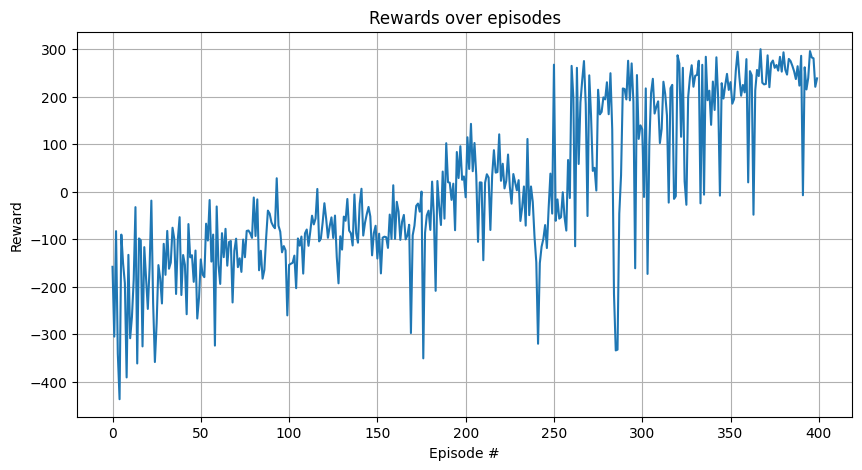

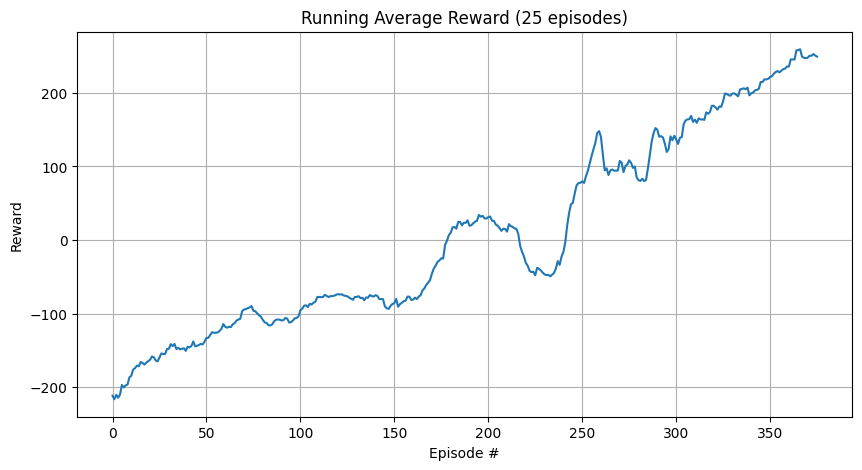

In [105]:
rewards_storer.plot_rewards()
rewards_storer.plot_rewards_smooth(window_length=25)

### Deep Q-Netowrk with CNN architecture

In [ ]:
env = gym.make('CarRacing-v3', continuous=False)
env = FrameStackObservation(env, 4)
# print(env.observation_space)
n_actions, n_observations = env.action_space.n, env.observation_space.shape
n_observations = (n_observations[1], n_observations[2], n_observations[0])  # (height, width, frames)

# print(n_actions, n_observations)
START_SKIP = 15 # to skip the nth frames at the beginning of the episode
dqn_agent = DQNAgent(
    model='DQN_CNN',
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.02,
    epsilon_decay=1e-5,
    tau=0.005,
    lr=1e-4,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)

rewards_storer = PlotResults()
n_episodes = 100

for episode in range(n_episodes):
    state, _ = env.reset()
    for _ in range(START_SKIP):
        # Take random actions during the skip phase
        random_action = np.random.randint(n_actions)
        state, _, _, _, _ = env.step(random_action)
    
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Preprocess the next state
        next_state = preprocess_state(next_state)

        # Store the transition in the replay buffer
        dqn_agent.store_transition(state, action, next_state, reward, done)

        # Train the agent
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 1 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")



Episode 0, Average Reward: -59.16, Epsilon: 0.94
Episode 1, Average Reward: -59.53, Epsilon: 0.93
Episode 2, Average Reward: -60.82, Epsilon: 0.92
Episode 3, Average Reward: -60.59, Epsilon: 0.91
Episode 4, Average Reward: -62.04, Epsilon: 0.90
Episode 5, Average Reward: -63.00, Epsilon: 0.90
Episode 6, Average Reward: -63.60, Epsilon: 0.89
Episode 7, Average Reward: -61.75, Epsilon: 0.88
Episode 8, Average Reward: -61.61, Epsilon: 0.87
Episode 9, Average Reward: -61.87, Epsilon: 0.86
Episode 10, Average Reward: -62.11, Epsilon: 0.85
Episode 11, Average Reward: -62.99, Epsilon: 0.84
Episode 12, Average Reward: -63.05, Epsilon: 0.83
Episode 13, Average Reward: -62.61, Epsilon: 0.82
Episode 14, Average Reward: -61.41, Epsilon: 0.81
Episode 15, Average Reward: -59.73, Epsilon: 0.80
Episode 16, Average Reward: -58.02, Epsilon: 0.79
Episode 17, Average Reward: -59.12, Epsilon: 0.79
Episode 18, Average Reward: -57.87, Epsilon: 0.78
Episode 19, Average Reward: -58.22, Epsilon: 0.77
Episode 20

401


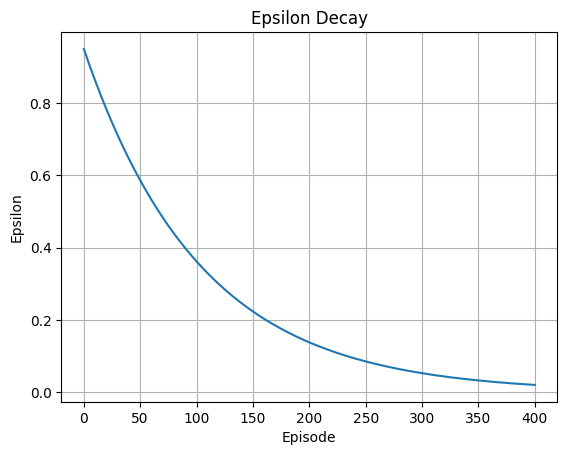

In [13]:
show_epsilon_decay(0.95, 0.02, 400)

In [74]:
tmp_env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=False)
tmp_env = FrameStackObservation(tmp_env, 4)
# wrap the env in the record video
env = gym.wrappers.RecordVideo(env=tmp_env, video_folder="video", episode_trigger=lambda x: True)

state, _ = env.reset()
# Start the recorder
env.start_recording('test')

test_episodes = 5
# AI logic
for episode in range(test_episodes):
    state, _ = env.reset()
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # Reduce state and next_state to greyscale
        next_state = preprocess_state(next_state)

        state = next_state
        total_reward += reward


env.stop_recording()

# Close the environment
env.close()

c:\Users\tfore\anaconda3\envs\DeepRL\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\tfore\Desktop\INF8225_Project\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\tfore\anaconda3\envs\DeepRL\lib\site-packages\gymnasium\wrappers\rendering.py:395: UserWarning: WARN: Ignored saving a video as there were zero frames to save.
  logger.warn("Ignored saving a video as there were zero frames to save.")
